In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from googletrans import Translator
from langid import classify
from tqdm.notebook import trange

from nltk.corpus import stopwords

import re
import pymorphy2

import yaml

import import_ipynb
from parse_1 import txt_file_to_list, record_file

import warnings
warnings.filterwarnings("ignore")

# 1.Препроцессинг

Считываю данные из файла, перевожу комментарии на русский язык (так как есть комментарии не на русском), очищаю, убираю из комментариев стоп-слова и провожу лемматизацию для облегечения анализа.

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [4]:
comments_file = config['parse']['comments']

In [5]:
comments = txt_file_to_list(comments_file)

In [6]:
def drop_duplicates(lst: list) -> list:
    """
    Удаление дубликатов из списка
    :params lst: список с дубликатами
    :return: список без дупликатов
    """
    return list(set(lst))

In [7]:
# В файле при парсинге сложились дупликаты комментариев, удалим их
comments = drop_duplicates(comments)

In [8]:
def drop_empty_elements(lst: list[str]) -> list[str]:
    """
    Удаление пустых строк из списка
    :params lst: список с пустыми строками
    :return: список без пустых строк
    """
    while True:
        try:
            lst.remove('')
        except ValueError:
            break
    
    return lst

In [9]:
# В списке есть пустые строки, которые мешают дальнейшей обработке. Удалим их.
comments = drop_empty_elements(comments)

In [10]:
def translator_from_to(lst: list[str], dest: str) -> list[str]:
    """
    Перевод всех элементов в списке с разных языков на конкретный
    :params lst: список, элементы которого нужно перевести
    :params dest: язык, на который нужно перевести строки из списка
    :return: список с переведенными строками
    """
    translator = Translator()
    for i in trange(len(lst)):
        try:
            lang = classify(lst[i])[0]
            if lang != dest:
                translation = translator.translate(
                    text=lst[i], src=lang, dest=dest)
                lst[i] = translation.text
        except ValueError:
            translation = translator.translate(
                text=lst[i], src='en', dest=dest)
            lst[i] = translation.text

    return lst


In [11]:
dest = config['preprocessing']['dest']

In [54]:
comments = translator_from_to(comments, dest)

  0%|          | 0/40903 [00:00<?, ?it/s]

In [12]:
file_comments_translated = config['preprocessing']['commets_translated']

In [57]:
# Сохраню переведенные комментарии в файл, чтобы не переводить их заново
record_file(file_comments_translated, comments)

In [13]:
# comments = txt_file_to_list(file_comments_translated)

In [14]:
def preprocess_text(
        text: str, stopwords: list[str] = stopwords.words('russian')
    ) -> str:
    """
    Очистка текста и удаление стоп-слов
    :params text: необработанная строка
    :params stopwords: список стоп-слов (по умолчанию русские стоп-слова)
    :return: строка после обработки
    """
    text = re.sub('ё', 'е', text.lower())
    text = re.sub(r'([.,!?-])', r' \1 ', text)
    text = re.sub(r'[^а-яА-Я\s]+', '', text)
    text = text.strip()
    text = [i for i in text.split() if i not in stopwords]
    text = [i for i in text if len(i) >= 3]
    text = ' '.join(text)

    return text


def lemmatization_text(text: str) -> str:
    """
    Приведение слов в строке к начальной форме
    :params text: необработанная строка
    :return: обработанная строка
    """
    morph = pymorphy2.MorphAnalyzer()
    text = ' '.join(morph.parse(i)[0].normal_form for i in text.split())

    return text


In [15]:
def list_with_strings_preproc(
        lst: list[str], preprocessor, lemmatizator
    ) -> list[str]:
    """
    Удаление стоп-слов, приведение слов в строке в списке к начальной форме
    и удаление из списка NaN и пустых строк
    :params lst: список с необработанными строками
    :params preprocessor: функция, очищающая строку и удаляющая стоп-слова
    :params lemmatizator: функция, приводящая слова в строке к начальной форме
    :return: список с обработанными строками
    """
    for i in range(len(lst)):
        lst[i] = preprocessor(lst[i])
        lst[i] = lemmatizator(lst[i])
    lst = [i for i in lst if i not in [None, '']]
    return lst

In [17]:
comments = list_with_strings_preproc(comments, 
                                     preprocess_text, 
                                     lemmatization_text)

In [25]:
file_comments_preprocessed = config['preprocessing']['comments_preprocessed']

In [63]:
# Сохраню полученные комментарии в файл
record_file(file_comments_preprocessed, comments)

# 2.EDA

Провожу небольшой разведочный анализ. Подсчитываю количество слов в комментариях. Вывожу наиболее частые слова.

## 2.1. Общая информация, подсчет количества слов в комментариях

In [28]:
def word_count(text: str) -> int:
    """
    Подсчет кол-ва слов в тексте
    :params text: строка, в которой считается кол-во слов
    :return: кол-во слов в строке
    """
    return len(text.split(' '))

In [29]:
word_counts = np.array([word_count(doc) for doc in comments])

In [30]:
def describe(data: np.ndarray) -> None:
    """
    Вывод основных описательных статистик 
    :params data: массив с числами
    """
    print(f'count: {data.shape[0]}')
    print(f'mean: {data.mean()}')
    print(f'std: {data.std()}')
    print(f'min: {data.min()}')
    print(f'25%: {np.percentile(data, 25)}')
    print(f'50%: {np.percentile(data, 50)}')
    print(f'75%: {np.percentile(data, 75)}')
    print(f'max: {data.max()}')

In [31]:
describe(word_counts)


count: 40112
mean: 6.4986288392501
std: 9.148431857939793
min: 1
25%: 2.0
50%: 4.0
75%: 7.0
max: 496


В среднем комментарии содержат от 4 до 7 слов. Максимальная длина комментария почти 500 слов.

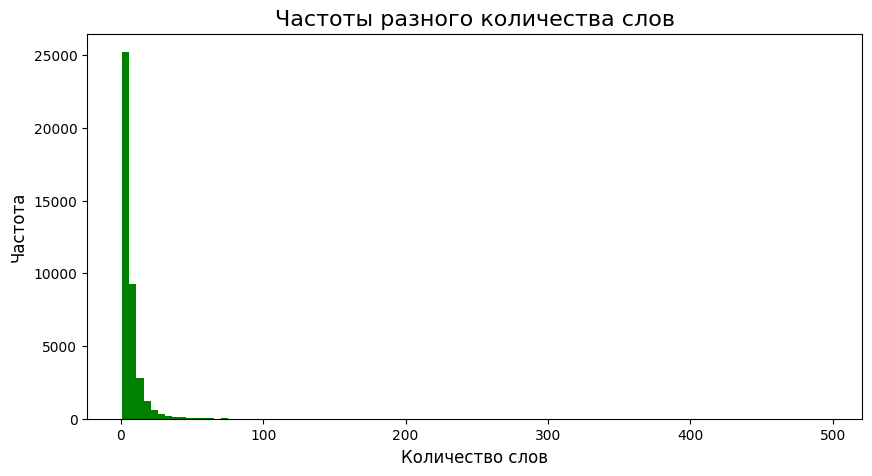

In [32]:
fig = plt.figure(figsize=(10,5))

plt.hist(
    word_counts,
    bins=100,
    color='green'
)

plt.title('Частоты разного количества слов', fontsize=16)
plt.ylabel('Частота', fontsize=12)
plt.xlabel('Количество слов', fontsize=12)


plt.show()

Подавляющее большинство комментариев содержат менее 50 слов.

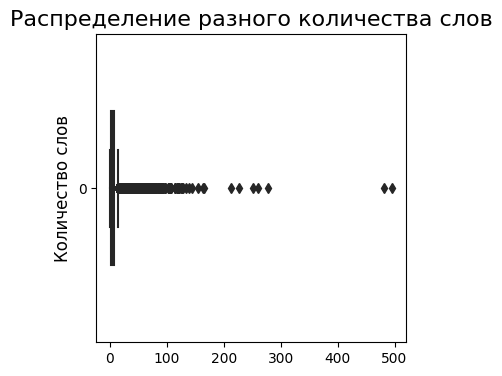

In [34]:
fig = plt.figure(figsize=(4,4))

sns.boxplot(
    word_counts,
    orient='h',
    width=.5,
    color='green'
)

plt.ylabel("Количество слов", fontsize=12)
plt.title('Распределение разного количества слов', fontsize=16)


plt.show()

Много выбросов - комментариев с количеством слов больше 50.

## 2.2. Вывод топ наиболее встречаемых слов в комментариях

In [78]:
def top_n_words(data: list[str], n: int) -> pd.DataFrame:
    """
    Составление таблицы с топ n словами в тексте
    :params data: список строк-документов
    :params n: число топ слов
    :return: таблица с двумя колонками: слово(н-грамма) и частота этого слова в
             документе
    """
    top_n = pd.DataFrame(
            Counter(data).most_common(n),
            columns=['word', 'frequency']
    )
    return top_n

In [79]:
top_n = config['preprocessing']['top_n']

In [80]:
top_n_dataframe = top_n_words(comments, top_n)

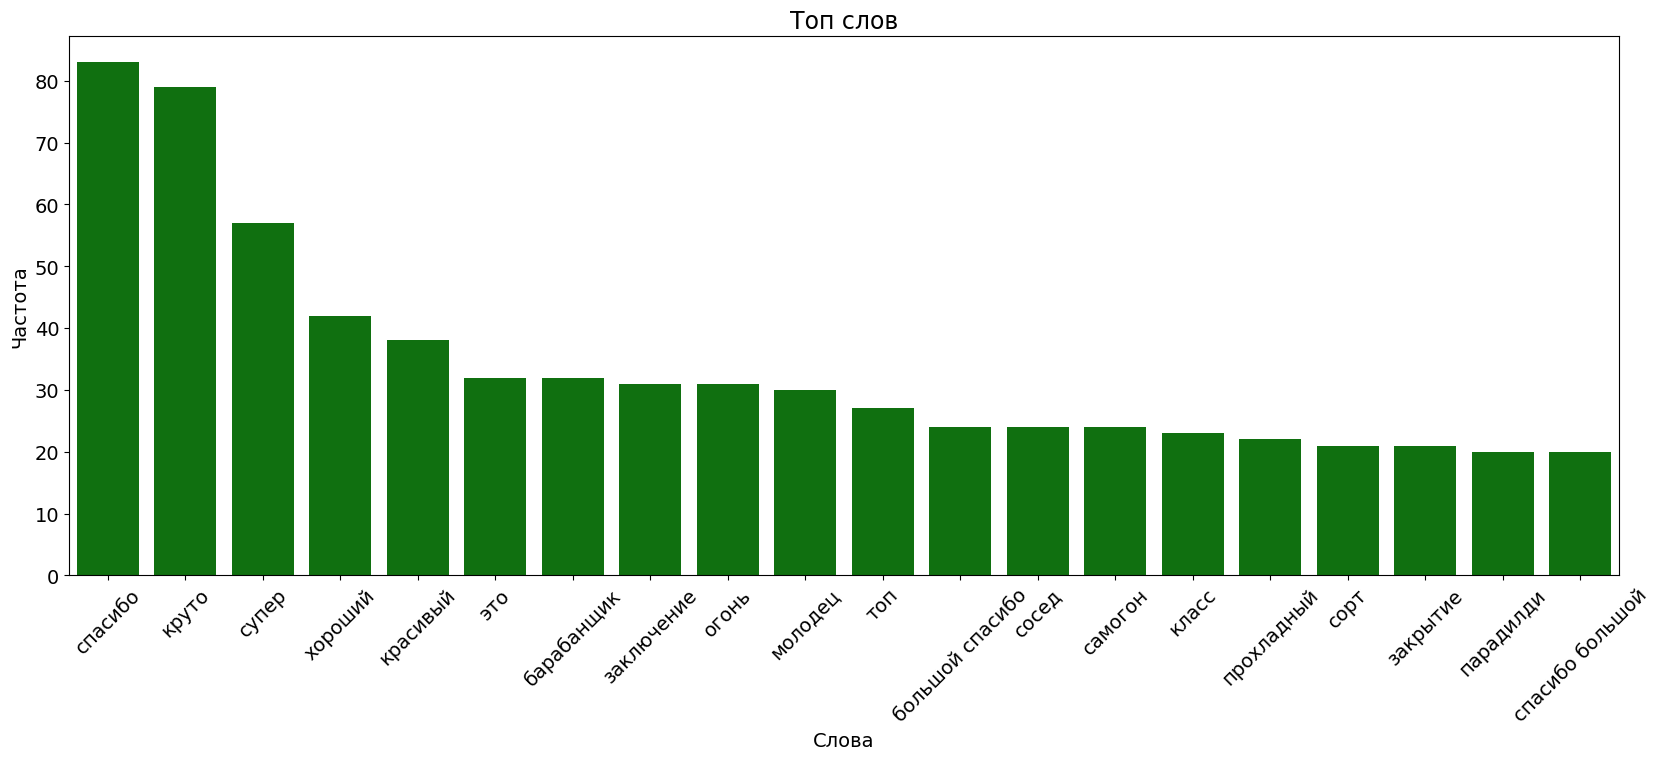

In [81]:
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_n_dataframe,
    color='green'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Слова', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Топ слов', fontsize=17)


plt.show()

Большинство комментариев содержат слова благодарностей за видео. Есть слова, которые пишут в поддержку музыканта.